In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import skew, entropy
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Load images

In [2]:
# Input: path directory
def load(path):
    files = os.listdir(path)
    images = []
    for file in tqdm(files):
        bgr_image = cv2.imread(path+'/'+file)
        # Convert from BGR to RGB
        rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
        images.append(rgb_image)
    
    return np.array(images)
# Output: array containing all images

In [3]:
early_images = load('../input/potato-leaf/Potato/Train/Potato___Early_blight')
late_images = load('../input/potato-leaf/Potato/Train/Potato___Late_blight')
healthy_images = load('../input/potato-leaf/Potato/Train/Potato___healthy')

100%|██████████| 300/300 [00:02<00:00, 118.81it/s]


# Put all image arrays in a new large array 
Sequence: early, late, healthy

In [4]:
all_images = np.append(early_images, late_images, axis=0)
all_images = np.append(all_images, healthy_images, axis=0)
all_images.shape

(900, 256, 256, 3)

# Function to extract color feature

The input is an array containing leaf images

In [5]:
# Input: Array of images and the color to process
def extract_color_features(images, color):
    means = []
    stds = []
    entropies = []
    skews = []
    
    if color == 'red':
        channel = 0
    elif color == 'green':
        channel = 1
    elif color == 'blue':
        channel = 2
    
    for image in tqdm(images):
        # Single-color image
        image = image[:,:,channel]
        
        means.append(np.mean(image.flatten()))
        stds.append(np.std(image.flatten()))
        entropies.append(entropy(image.flatten()))
        skews.append(skew(image.flatten()))
    
    return np.array([means, stds, entropies, skews])
# Output: Features of a single-color image

In [6]:
color_features_red = extract_color_features(all_images, 'red')
color_features_green = extract_color_features(all_images, 'green')
color_features_blue = extract_color_features(all_images, 'blue')

100%|██████████| 900/900 [00:03<00:00, 246.43it/s]


In [7]:
print(color_features_red.shape)
print(color_features_green.shape)
print(color_features_blue.shape)

(4, 900)
(4, 900)
(4, 900)


# Transpose, such that the column represents feature
(Before being transposed, the features are represented by rows)

In [8]:
color_features_red = color_features_red.T
color_features_green = color_features_green.T
color_features_blue = color_features_blue.T
print(color_features_red.shape)
print(color_features_green.shape)
print(color_features_blue.shape)

(900, 4)
(900, 4)
(900, 4)


In [9]:
color_features = np.hstack((color_features_red, 
                            color_features_green, 
                            color_features_blue))
color_features.shape

(900, 12)

# Create color data frame

In [10]:
column_names = ['red_mean', 'red_std', 'red_entropy', 'red_skew', 
                'green_mean', 'green_std', 'green_entropy', 'green_skew', 
                'blue_mean', 'blue_std', 'blue_entropy', 'blue_skew',]
df_color = pd.DataFrame(color_features, columns=column_names)
df_color.head()

,red_mean,red_std,red_entropy,red_skew,green_mean,green_std,green_entropy,green_skew,blue_mean,blue_std,blue_entropy,blue_skew
0,128.241333,51.737705,10.990071,-0.624883,137.095535,48.714020,11.008722,-1.053940,119.567703,59.338702,10.940792,-0.269785
1,131.793427,59.589214,10.964616,-0.539912,127.263321,61.496944,10.944236,-0.489747,112.865601,67.527586,10.866736,-0.174657
2,151.269608,54.522367,11.009266,-0.925199,144.756012,56.837316,10.993506,-0.802413,110.945511,57.555319,10.928798,-0.221356
3,137.720428,48.946596,11.012785,-0.754182,143.154617,49.604567,11.015438,-0.835116,114.887405,57.885081,10.934387,-0.305215
4,145.950607,42.962288,11.041317,-0.509513,151.136169,38.517985,11.051200,-1.074406,120.008102,52.886707,10.982126,-0.024154


# Function to extract texture features
The input is an array of images

In [11]:
# Input: array of images
def extract_texture_features(images):
    
    means = []
    stds = []
    contrasts = []
    correlations = []
    energies = []
    homogeneities = []
    
    for image in tqdm(images):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Gray-Level Co-occurrence matrix (GLCM)
        glcm = greycomatrix(image, distances=[1], angles=[0])
        
        mean = np.mean(glcm.flatten())
        std = np.std(glcm.flatten())
        contrast = greycoprops(glcm, 'contrast')
        correlation = greycoprops(glcm, 'correlation')
        energy = greycoprops(glcm, 'energy')
        homogeneity = greycoprops(glcm, 'homogeneity')
        
        means.append(mean)
        stds.append(std)
        contrasts.append(contrast)
        correlations.append(correlation)
        energies.append(energy)
        homogeneities.append(homogeneity)
    
    # Reshape contrasts, correlations, energies and 
    # homogenities to 900 since by default the number
    # of axes are too many
    contrasts = np.array(contrasts).reshape(900)
    correlations = np.array(correlations).reshape(900)
    energies = np.array(energies).reshape(900)
    homogeneities = np.array(homogeneities).reshape(900)
    
    return np.array([means, stds, contrasts, correlations, 
                     energies, homogeneities])

# Transpose, similar to the color feature extraction above

In [12]:
texture_features = extract_texture_features(all_images)
print('Before transpose:', texture_features.shape)
texture_features = texture_features.T
print('After transpose\t:', texture_features.shape)

100%|██████████| 900/900 [00:03<00:00, 244.62it/s]

Before transpose: (6, 900)
After transpose	: (900, 6)


# Data frame for storing texture features

In [13]:
column_names = ['texture_mean', 'texture_std', 'contrast', 
                'correlation', 'energy', 'homogeneity']
df_texture = pd.DataFrame(texture_features, columns=column_names)
df_texture.head()

,texture_mean,texture_std,contrast,correlation,energy,homogeneity
0,0.996094,3.829064,744.379259,0.852852,0.015516,0.116177
1,0.996094,2.893719,1070.296278,0.855990,0.012001,0.099745
2,0.996094,3.732137,577.962163,0.903653,0.015148,0.114060
3,0.996094,3.168725,890.007077,0.813707,0.013026,0.082282
4,0.996094,2.910628,745.161673,0.770440,0.012064,0.078647


# Function to extract shape features

In [14]:
def extract_shape_features(images):
    areas = []
    perimeters = []
    major_axis_lengths = []
    minor_axis_lengths = []
    eccentricities = []
    
    for image in tqdm(images):
        # Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Convert to binary (if < 127 then 0, else 225)
        _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        # Normalization, so the value is only either 0 or 1
        image = image / 255
        
        label_image = label(image)
        regions = regionprops(label_image)
        
        # Regions are small objects detected in the picture.
        largest_area_index = np.argmax([region.area for region in regions])
        
        area = regions[largest_area_index].area
        perimeter = regions[largest_area_index].perimeter
        major_axis_length = regions[largest_area_index].major_axis_length
        minor_axis_length = regions[largest_area_index].minor_axis_length
        eccentricity = regions[largest_area_index].eccentricity
        
        areas.append(area)
        perimeters.append(perimeter)
        major_axis_lengths.append(major_axis_length)
        minor_axis_lengths.append(minor_axis_length)
        eccentricities.append(eccentricity)
    
    return np.array([areas, perimeters, major_axis_lengths, 
                     minor_axis_lengths, eccentricities])


In [15]:
shape_features = extract_shape_features(all_images)
print('Before transpose:', shape_features.shape)
shape_features = shape_features.T
print('After transpose\t:', shape_features.shape)

100%|██████████| 900/900 [00:14<00:00, 60.53it/s]

Before transpose: (5, 900)
After transpose	: (900, 5)


In [16]:
column_names = ['area', 'perimeter', 'major_axis_length', 
                'minor_axis_length', 'eccentricity']
df_shape = pd.DataFrame(shape_features, columns=column_names)
df_shape.head()

,area,perimeter,major_axis_length,minor_axis_length,eccentricity
0,38979.0,10987.430622,347.656468,275.955893,0.608231
1,26411.0,6412.273842,320.003857,205.865950,0.765595
2,40083.0,7721.017275,318.375217,234.736768,0.675570
3,39783.0,11058.414603,310.329888,255.356120,0.568253
4,46784.0,12974.765071,323.029398,298.317639,0.383599


# Put all data frames to a single large df

In [17]:
df = pd.concat([df_color, df_texture, df_shape], axis=1)
print('df_color.shape\t\t:', df_color.shape)
print('df_texture.shape\t:', df_texture.shape)
print('df_shape.shape\t\t:', df_shape.shape)
print('df.shape \t\t:', df.shape)

df_color.shape		: (900, 12)
df_texture.shape	: (900, 6)
df_shape.shape		: (900, 5)
df.shape 		: (900, 23)


# Create label

In [18]:
df['label'] = np.array([0] * 300 + [1] * 300 + [2] * 300)
df.shape

(900, 24)

# Train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], 
                                                    df.iloc[:,-1], 
                                                    test_size=0.2)

In [20]:
print(X_train.shape)
print(X_test.shape)

(720, 23)
(180, 23)


# SVM

In [24]:
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, y_train)
print('Train accuracy\t:', clf_linear.score(X_train, y_train))
print('Test accuracy\t:', clf_linear.score(X_test, y_test))

Train accuracy	: 0.9666666666666667
Test accuracy	: 0.9388888888888889


In [25]:
clf_poly = SVC(kernel='poly')
clf_poly.fit(X_train, y_train)
print('Train accuracy\t:', clf_poly.score(X_train, y_train))
print('Test accuracy\t:', clf_poly.score(X_test, y_test))

Train accuracy	: 0.7166666666666667
Test accuracy	: 0.7666666666666667


In [26]:
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)
print('Train accuracy\t:', clf_rbf.score(X_train, y_train))
print('Test accuracy\t:', clf_rbf.score(X_test, y_test))

Train accuracy	: 0.7125
Test accuracy	: 0.7444444444444445


# Prediction results

In [27]:
# Predicting test data
test_preds = clf_linear.predict(X_test)
test_preds

array([1, 2, 1, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 0,
       0, 1, 2, 1, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1,
       0, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2,
       2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2,
       2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 2,
       1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1,
       2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 1,
       2, 1, 2, 1])

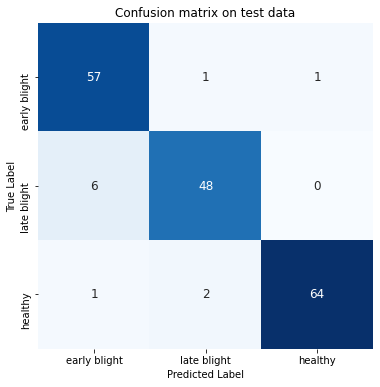

In [28]:
# Compare the predicted label with the actual
cm = confusion_matrix(y_test, test_preds)

label_names = ['early blight', 'late blight', 'healthy']

plt.figure(figsize=(6,6))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', 
            cmap=plt.cm.Blues, cbar=False, 
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={'size':12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Footnotes

In [29]:
testes = all_images[800]

([], <a list of 0 Text major ticklabel objects>)

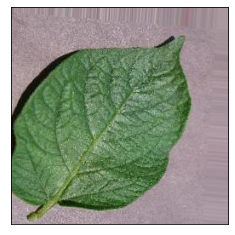

In [30]:
plt.imshow(testes)
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

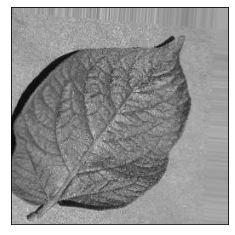

In [31]:
testes = cv2.cvtColor(testes, cv2.COLOR_RGB2GRAY)
plt.imshow(testes, cmap='gray')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

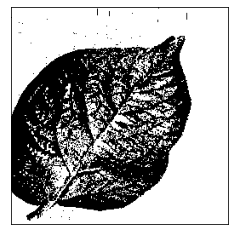

In [32]:
_, testes = cv2.threshold(testes, 127, 255, cv2.THRESH_BINARY)
testes = testes / 255
plt.imshow(testes, cmap='gray')
plt.xticks([])
plt.yticks([])